In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.models.vgg import VGG16_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
IMG_PATH = '/content/drive/MyDrive/CV Bootcamp/Project-1/Dataset/Images'
FILE_PATH = '/content/drive/MyDrive/CV Bootcamp/Project-1/Dataset'

In [ ]:
n_images = len(os.listdir(IMG_PATH))
print("Total Images in the Dataset : ", n_images)

Total Images in the Dataset :  5017


In [ ]:
onlyfiles = [f for f in listdir(IMG_PATH) if isfile(join(IMG_PATH, f))]

In [ ]:
data = pd.read_csv(os.path.join(FILE_PATH, 'list_attribute.txt'), delimiter=r'\s+', skiprows=1).reset_index()# load data from file provided
data.rename(columns = {'index':'image_id'}, inplace = True)
data.replace(-1, 0, inplace=True)
data = data[data.image_id.isin(onlyfiles)]
data.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
50,000051.jpg,1,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
51,000052.jpg,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
64,000065.jpg,0,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,1
165,000166.jpg,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
197,000198.jpg,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [ ]:
data.loc[data['Male'] == -1,'Male'] = 0
data.loc[data['Male'] == 1,'Male'] = 1

col_list = ['image_id', 'Male']
data = data[col_list]

data = data.reset_index(drop=True)

data.head()

,image_id,Male
0,000051.jpg,1
1,000052.jpg,1
2,000065.jpg,1
3,000166.jpg,1
4,000198.jpg,0


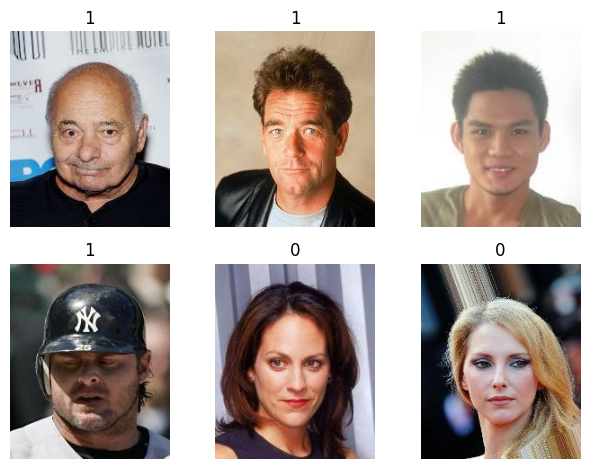

In [ ]:
for i in range(0, 6):
    plt.subplot(2, 3, i+1)

    # Read an Image.
    img = cv2.imread(IMG_PATH + '/' + data['image_id'][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display Image.
    plt.imshow(img)
    plt.title(data["Male"][i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
category_count = data["Male"].value_counts()
print(category_count)

higher_category = list(category_count.index)[0]

0    2953
1    2047
Name: Male, dtype: int64


In [ ]:
np.random.seed(42)
indices = data[data["Male"] == higher_category].index
sample_size = category_count[0] - category_count[1]

# Drop the extra rows of female images to fix class imbalance problem.
drop_sample = np.random.choice(indices, sample_size, replace = False)
df = data.drop(drop_sample, axis = "index")

<Axes: >

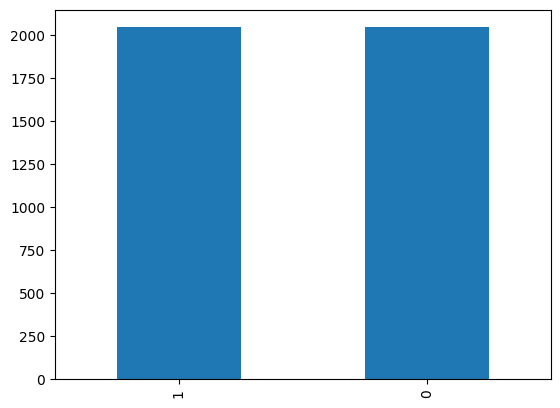

In [ ]:
df["Male"].value_counts().plot.bar()

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.3)

In [ ]:
print("Total Train Sample Images : ", len(train_df))
print("Total Test Sample Images : ", len(test_df))

Total Train Sample Images :  2865
Total Test Sample Images :  1229


In [ ]:
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = IMG_PATH + '/' + self.dataframe.iloc[idx, 0]
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)

        label = self.dataframe.iloc[idx, 1]
        return image, torch.tensor(label)

In [ ]:
BATCH_SIZE = 16
train_dataset = CustomDataset(train_df, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
test_dataset = CustomDataset(test_df, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)
model.fc=nn.Sequential(
    nn.Linear(in_features=1024,out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512,out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128,out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32,out_features=1),
    nn.Sigmoid()
)
model.to('cuda');

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:02<00:00, 24.3MB/s]


In [ ]:
summary(model, input_size=(3, 218, 178))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 109, 89]           9,408
       BatchNorm2d-2          [-1, 64, 109, 89]             128
       BasicConv2d-3          [-1, 64, 109, 89]               0
         MaxPool2d-4           [-1, 64, 54, 44]               0
            Conv2d-5           [-1, 64, 54, 44]           4,096
       BatchNorm2d-6           [-1, 64, 54, 44]             128
       BasicConv2d-7           [-1, 64, 54, 44]               0
            Conv2d-8          [-1, 192, 54, 44]         110,592
       BatchNorm2d-9          [-1, 192, 54, 44]             384
      BasicConv2d-10          [-1, 192, 54, 44]               0
        MaxPool2d-11          [-1, 192, 27, 22]               0
           Conv2d-12           [-1, 64, 27, 22]          12,288
      BatchNorm2d-13           [-1, 64, 27, 22]             128
      BasicConv2d-14           [-1, 64,

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
epochs = 30
model.train()
loss_vals =  []
for epoch in range(epochs):
    running_loss = 0.0
    epoch_loss =  []
    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs).reshape(-1)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        # Print statistics
        epoch_loss.append(loss.item())
        running_loss += loss.item()

    loss_vals.append(sum(epoch_loss)/len(epoch_loss))
    print(f'Epoch: {epoch + 1}, Loss: {running_loss}')


# Test the model
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model(images).reshape(-1)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels.float()).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

print('Finished Training')

Epoch: 1, Loss: 58.48237996175885
Epoch: 2, Loss: 24.706644028425217
Epoch: 3, Loss: 17.554359912872314
Epoch: 4, Loss: 11.390349869383499
Epoch: 5, Loss: 10.04696916276589
Epoch: 6, Loss: 9.901917855604552
Epoch: 7, Loss: 9.72234566215775
Epoch: 8, Loss: 9.620901068672538
Epoch: 9, Loss: 5.341201896866551
Epoch: 10, Loss: 8.42173634408391
Epoch: 11, Loss: 4.841406832973007
Epoch: 12, Loss: 5.671127872876241
Epoch: 13, Loss: 7.699723138153786
Epoch: 14, Loss: 6.071396380284568
Epoch: 15, Loss: 3.933200619794661
Epoch: 16, Loss: 2.8944560174204526
Epoch: 17, Loss: 1.3939642785917385
Epoch: 18, Loss: 1.4626996367514948
Epoch: 19, Loss: 1.9686806550416804
Epoch: 20, Loss: 3.5794832617684733
Epoch: 21, Loss: 2.379026546877867
Epoch: 22, Loss: 7.365159282372588
Epoch: 23, Loss: 3.8259226824739017
Epoch: 24, Loss: 8.766727364010876
Epoch: 25, Loss: 2.401205801870674
Epoch: 26, Loss: 0.45808312764711445
Epoch: 27, Loss: 2.5274737358377024
Epoch: 28, Loss: 1.5432943662653997
Epoch: 29, Loss: 3

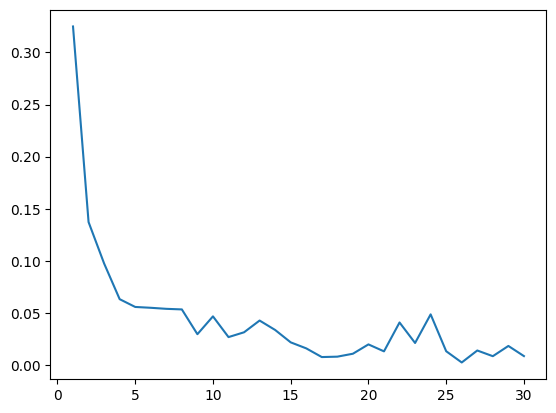

In [ ]:
plt.plot(np.linspace(1, epochs, epochs).astype(int), loss_vals)
plt.show()

In [ ]:
torch.save(model.state_dict(), FILE_PATH + "/" + "google_net_96.pth")

In [ ]:
model.load_state_dict(torch.load(FILE_PATH + "/" + "google_net_96.pth"))

<All keys matched successfully>

In [ ]:
y_pred = []
y_true = []


for data in test_loader:
  images, labels = data
  images, labels = images.to('cuda'), labels.to('cuda')
  outputs = model(images).reshape(-1)


  predicted = (outputs > 0.5).float()
  y_pred.extend(predicted.to('cpu').numpy())

  labels = labels.data.float().cpu().numpy()
  y_true.extend(labels) # Save Truth

In [ ]:
label_true = ["Male" if ele == 1 else "Female" for ele in y_true]
label_pred = ["Male" if ele == 1 else "Female" for ele in y_pred]

In [ ]:
labels = ['Male','Female']

cm = confusion_matrix(label_true, label_pred, labels= labels)
cm

array([[606,  21],
       [ 19, 583]])

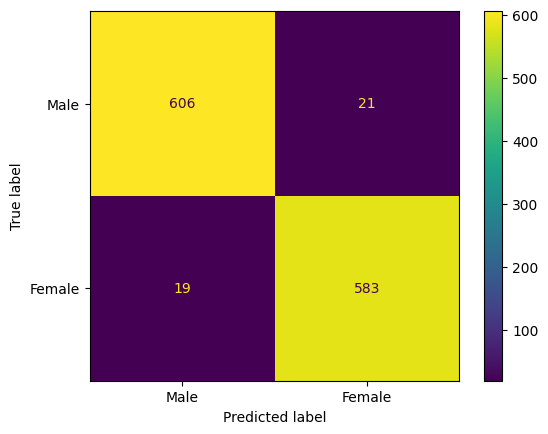

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

In [ ]:
temp_df = test_df.copy()
temp_df['label_true'] = label_true
temp_df['label_pred'] = label_pred
temp_df.head()

,image_id,Male,label_true,label_pred
2759,112013.jpg,1,Male,Male
4584,185530.jpg,0,Female,Female
3902,157170.jpg,1,Male,Male
3268,133341.jpg,0,Female,Female
1994,080117.jpg,1,Male,Male


In [ ]:
temp_df['True'] = temp_df.apply(lambda x: x['label_true'] == x['label_pred'], axis=1)

In [ ]:
temp_df.head()

,image_id,Male,label_true,label_pred,True
2759,112013.jpg,1,Male,Male,True
4584,185530.jpg,0,Female,Female,True
3902,157170.jpg,1,Male,Male,True
3268,133341.jpg,0,Female,Female,True
1994,080117.jpg,1,Male,Male,True


In [ ]:
false_image = temp_df.loc[temp_df['True'] == False][0:6]

false_image = false_image.reset_index(drop=True)

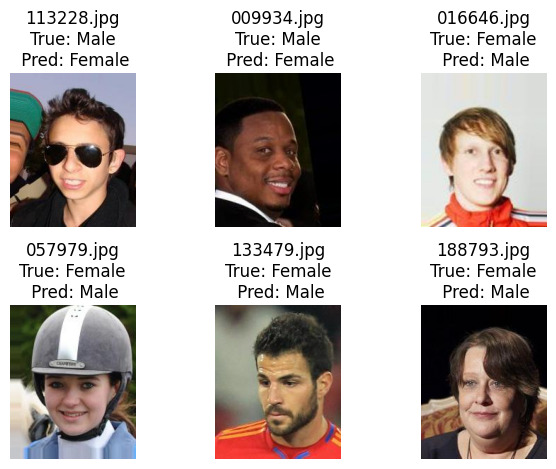

In [ ]:
for i in range(0, 6):
    plt.subplot(2, 3, i+1)

    # Read an Image.
    img = cv2.imread(IMG_PATH + '/' + false_image['image_id'][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display Image.
    plt.imshow(img)
    plt.title(false_image['image_id'][i] + '\nTrue: ' + false_image['label_true'][i] + '\n Pred: ' + false_image['label_pred'][i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
false_image

,image_id,Male,label_true,label_pred,True
0,113228.jpg,1,Male,Female,False
1,009934.jpg,1,Male,Female,False
2,016646.jpg,0,Female,Male,False
3,057979.jpg,0,Female,Male,False
4,133479.jpg,0,Female,Male,False
5,188793.jpg,0,Female,Male,False


In [ ]:
true_image = temp_df.loc[temp_df['True'] == True][0:6]

true_image = true_image.reset_index(drop=True)

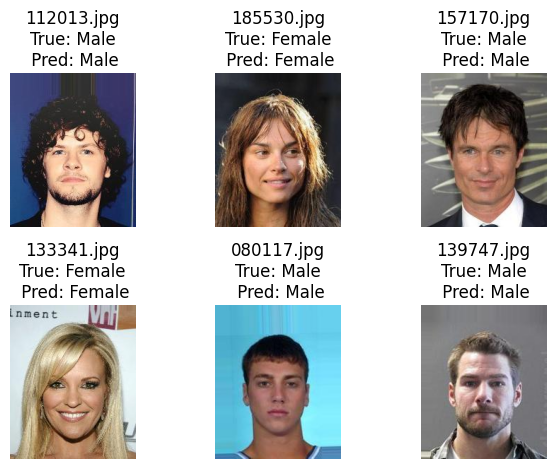

In [ ]:
for i in range(0, 6):
    plt.subplot(2, 3, i+1)

    # Read an Image.
    img = cv2.imread(IMG_PATH + '/' + true_image['image_id'][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display Image.
    plt.imshow(img)
    plt.title(true_image['image_id'][i] + '\nTrue: ' + true_image['label_true'][i] + '\n Pred: ' + true_image['label_pred'][i])
    plt.axis('off')

plt.tight_layout()
plt.show()